# Building a semantic segmentation model

Goal: to segment ships on satellite images. 

Method: U-net, Keras. 

Metric: Dice score

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
# from skimage.segmentation import mark_boundaries
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../input/airbus-ship-detection'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
import gc; gc.enable() # memory is tight

from skimage.morphology import label


def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def make_image_gen(in_df, batch_size = BATCH_SIZE):
    '''
    Take batches and normalize values of pixels
    '''
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Variables

In [ ]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 50
GAUSSIAN_NOISE = 0.1
# UPSAMPLE_MODE = 'DECONV'
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 500
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

# Load data and take train-valid dataset

Read a dataframe with masks and image's ids. 

In [3]:
masks = pd.read_csv(os.path.join('../input/airbus-ship-detection',
                                 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

 Choose only good images:

masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

Choosing take a lot of time, then we can use already loaded results:

In [4]:
# unique_img_ids.to_pickle('unique_img_ids.pkl')
unique_img_ids= pd.read_pickle ("/support/unique_img_ids.pkl")

#### Divide into train and validation sets:

In [5]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, shuffle = True,
                 stratify = unique_img_ids['ships'], random_state = 400) # let's stratify by goal and unbalanced column.
train_df = pd.merge(masks, train_ids) # add masks to train dataset
valid_df = pd.merge(masks, valid_ids) # add masks to validation dataset 
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


161048 training masks
69034 validation masks


# Train onto hole dataset

Dataset has more then 120000 images without ships and less images with 1-10 ships. 

<Axes: >

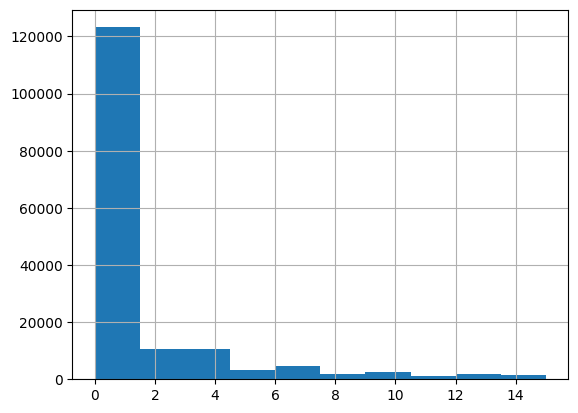

In [44]:
train_df['ships'].hist()

In [72]:
valid_df

ImageId                                      EncodedPixels  \
0      0001124c7.jpg                                                NaN   
1      000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...   
2      000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...   
3      000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...   
4      000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...   
...              ...                                                ...   
69029  fffdd2377.jpg  333603 7 334359 19 335120 26 335888 26 336656 ...   
69030  fffe646cf.jpg                                                NaN   
69031  fffedbb6b.jpg                                                NaN   
69032  ffff6e525.jpg                                                NaN   
69033  ffffc50b4.jpg                                                NaN   

       ships  has_ship has_ship_vec  file_size_kb  
0          0       0.0        [0.0]     76.059570  
1          5       1.0        [1.0]     75.221680  
2          5       1.0        [1.0]     75.221680  
3          5       1.0        [1.0]     75.221680  
4          5       1.0        [1.0]     75.221680  
...      ...       ...          ...           ...  
69029      1       1.0        [1.0]    393.797852  
69030      0       0.0        [0.0]    112.628906  
69031      0       0.0        [0.0]     93.918945  
69032      0       0.0        [0.0]    108.519531  
69033      0       0.0        [0.0]     98.344727  

[69034 rows x 6 columns]

<Axes: >

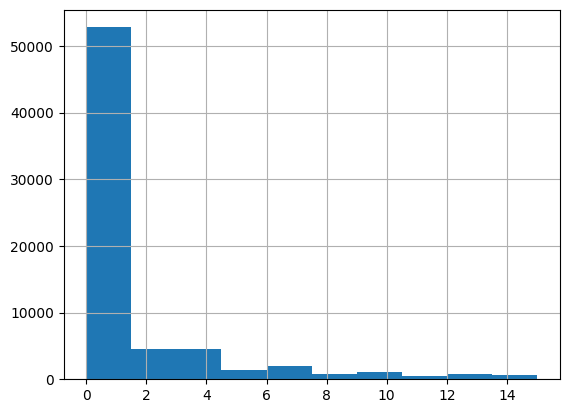

In [73]:
valid_df['ships'].hist()

### Sample is very imbalanced: not-ships images are plurality.

#### Use undersampling to take balanced sample

Divide train_df['ships'] into groups

In [ ]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)

example of grouping train dataframe

In [46]:
train_df

ImageId                                      EncodedPixels  \
0       00003e153.jpg                                                NaN   
1       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
2       0001b1832.jpg                                                NaN   
3       00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...   
4       00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...   
...               ...                                                ...   
161043  fffd924fb.jpg  198440 8 199208 8 199976 8 200744 8 201512 8 2...   
161044  fffe4c385.jpg                                                NaN   
161045  fffe4fa23.jpg                                                NaN   
161046  ffff2aa57.jpg                                                NaN   
161047  ffffe97f3.jpg                                                NaN   

        ships  has_ship has_ship_vec  file_size_kb  grouped_ship_count  
0           0       0.0        [0.0]    128.944336                   0  
1           1       1.0        [1.0]    147.625977                   1  
2           0       0.0        [0.0]     95.627930                   0  
3           9       1.0        [1.0]    242.910156                   5  
4           9       1.0        [1.0]    242.910156                   5  
...       ...       ...          ...           ...                 ...  
161043      2       1.0        [1.0]    126.369141                   1  
161044      0       0.0        [0.0]    345.860352                   0  
161045      0       0.0        [0.0]    220.440430                   0  
161046      0       0.0        [0.0]    191.762695                   0  
161047      0       0.0        [0.0]    113.900391                   0  

[161048 rows x 7 columns]

#### Based on groups 0-7 take balanced set with approximately equal sizes

In [13]:
def sample_ships(in_df, base_rep_val=1500):
    '''
    take ships not more base_rep_val; 
    if there are no-ships images, take 1/3 of base_rep_val sample
    if there is-ships images, take base_rep_val sample
    '''
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))

example of sampled train dataframe

In [14]:
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)

In [23]:
balanced_train_df.loc[7, :] # choose only group # 7

ImageId                                      EncodedPixels  \
11456   11f3bae66.jpg  394297 1 395065 5 395833 7 396600 8 397368 8 3...   
4360    06e50168c.jpg  100915 1 101681 4 102448 5 103214 8 103981 10 ...   
90794   8ff1e4f45.jpg  338532 2 339299 6 340067 9 340835 13 341603 16...   
63663   64deb1d16.jpg  108983 1 109750 4 110518 5 111285 7 112053 9 1...   
147545  ea9f82665.jpg  205906 6 206674 6 207442 6 208210 6 208978 6 2...   
...               ...                                                ...   
94912   96a40ad10.jpg  532833 1 533599 3 534366 5 535134 5 535903 5 5...   
141581  e1352a6d8.jpg  276768 2 277535 5 278303 7 279070 7 279838 7 2...   
24194   2659080c5.jpg  435823 1 436590 3 437357 5 438124 7 438891 9 4...   
98463   9c44c4502.jpg  398395 1 399162 3 399929 5 400696 7 401463 9 4...   
30246   2feda322f.jpg  429778 1 430545 3 431312 5 432079 7 432848 7 4...   

        ships  has_ship has_ship_vec  file_size_kb  grouped_ship_count  
11456      15       1.0        [1.0]     96.063477                   7  
4360       13       1.0        [1.0]     97.940430                   7  
90794      14       1.0        [1.0]    212.051758                   7  
63663      13       1.0        [1.0]    181.356445                   7  
147545     15       1.0        [1.0]    128.476562                   7  
...       ...       ...          ...           ...                 ...  
94912      15       1.0        [1.0]    143.139648                   7  
141581     14       1.0        [1.0]    127.943359                   7  
24194      14       1.0        [1.0]    111.117188                   7  
98463      13       1.0        [1.0]    127.792969                   7  
30246      13       1.0        [1.0]    228.059570                   7  

[1500 rows x 7 columns]

visualising of balanced train dataset

<Axes: >

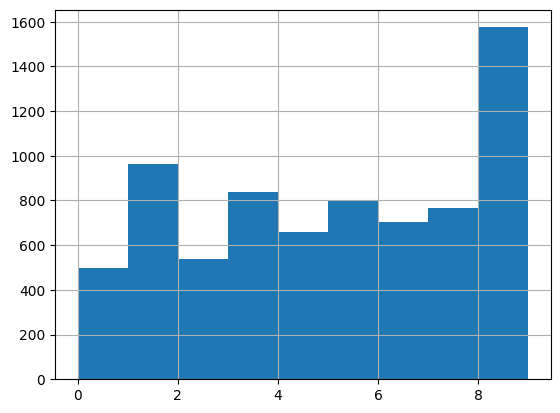

In [24]:

balanced_train_df['ships'].hist(bins=np.arange(10))

same operation with validation dataset

<Axes: >

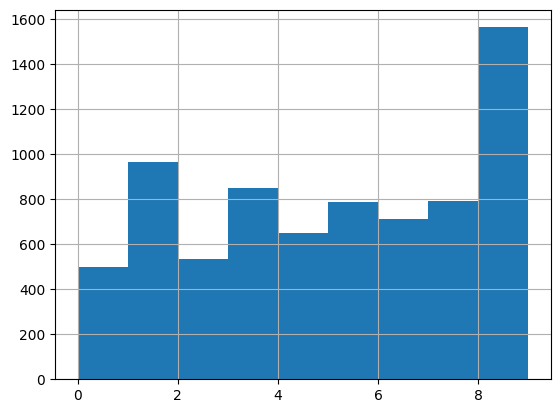

In [25]:
valid_df['grouped_ship_count'] = valid_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
balanced_validation_df = valid_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_validation_df['ships'].hist(bins=np.arange(10))

### Take batches and normalize values of pixels

dataset is huge, more 30 gb, then we create generator to batch-load of dataset

In [11]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    '''
    Take batches and normalize values of pixels
    '''
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        # np.random.shuffle(all_batches) if we use shuffle on train-test-split, we do not need suffle here
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values) # apply masks for images
            if IMG_SCALING is not None: # scale image if we want to scale here (other way - into neural netork)
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0) # create an generator
                out_rgb, out_mask=[], []

In [12]:
train_gen = make_image_gen(balanced_train_df, 4) # create a generator

# see an example of batch:
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


See an example a satellite image, mask and boundary

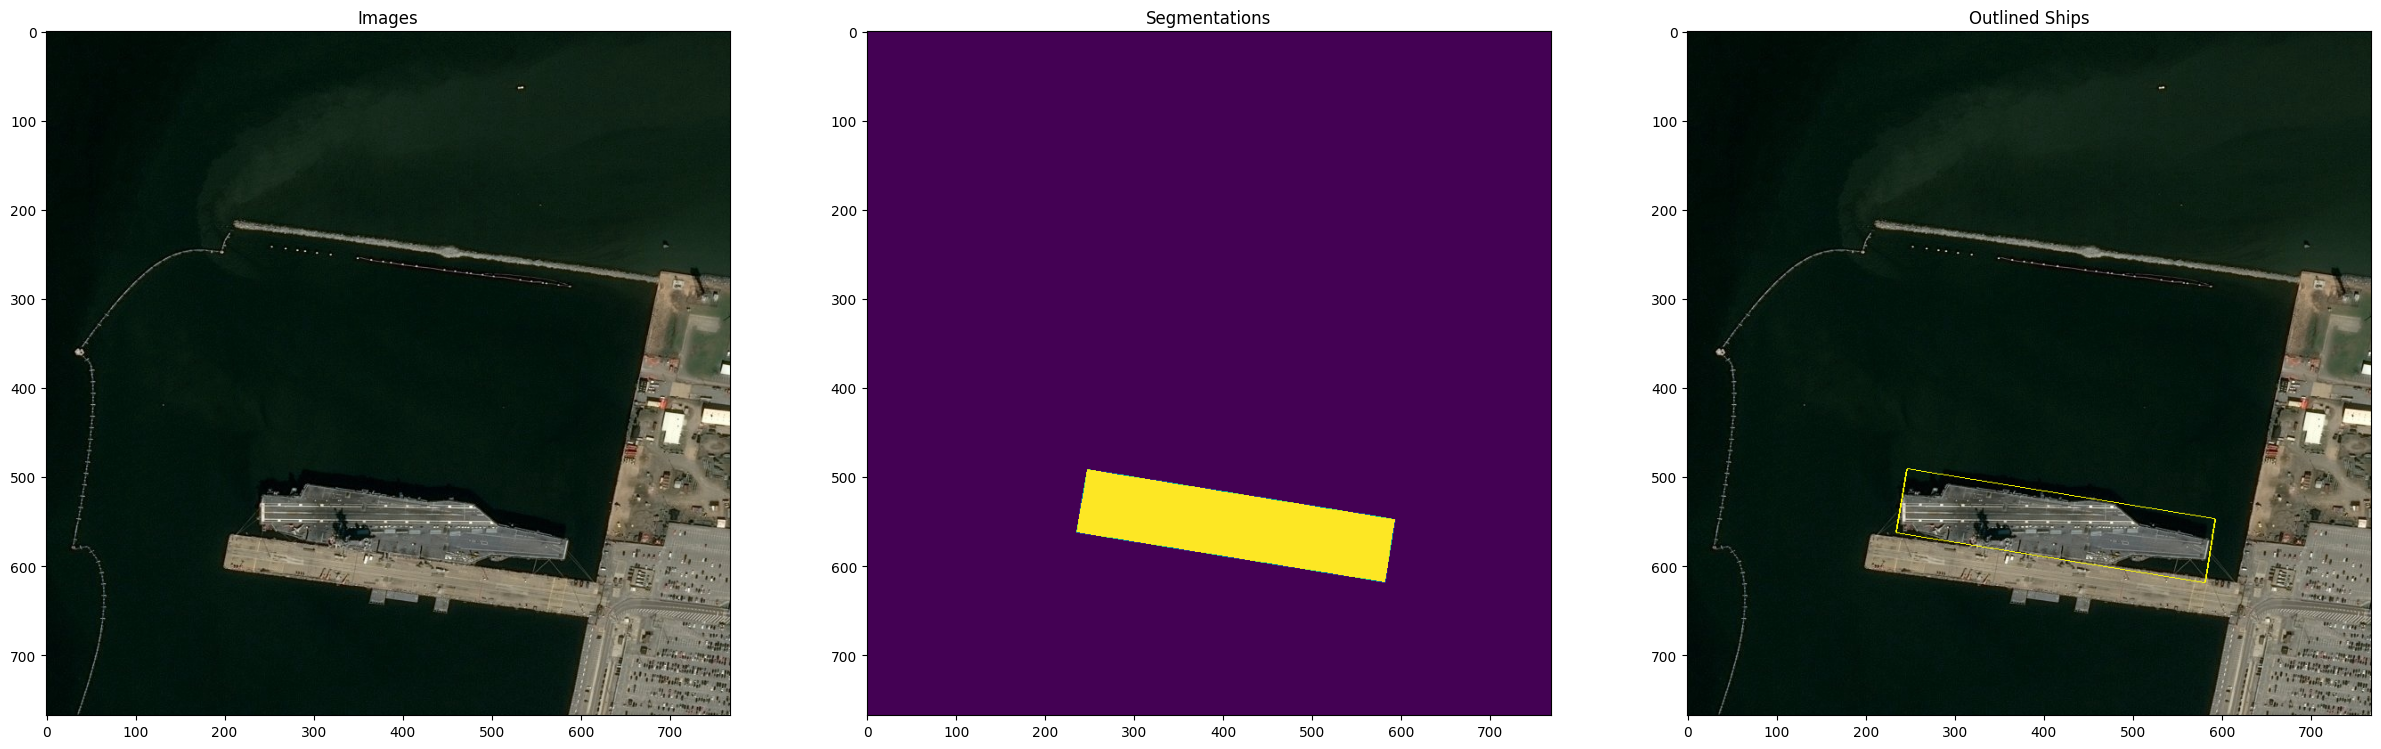

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

#### look at an example of batches of validation dataset

There are problem: if we use all validation dataset in the model training, we have a loss of memory. Maximal number of examples in the batch may be only 500 images. 

In [13]:
valid_x, valid_y = next(make_image_gen(balanced_validation_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(400, 768, 768, 3) (400, 768, 768, 1)


### Create image generator

We need some augmentation

In [14]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

see en example of augmented images:

x (4, 768, 768, 3) float32 0.0 1.0
y (4, 768, 768, 1) float32 0.0 1.0


Text(0.5, 1.0, 'ships')

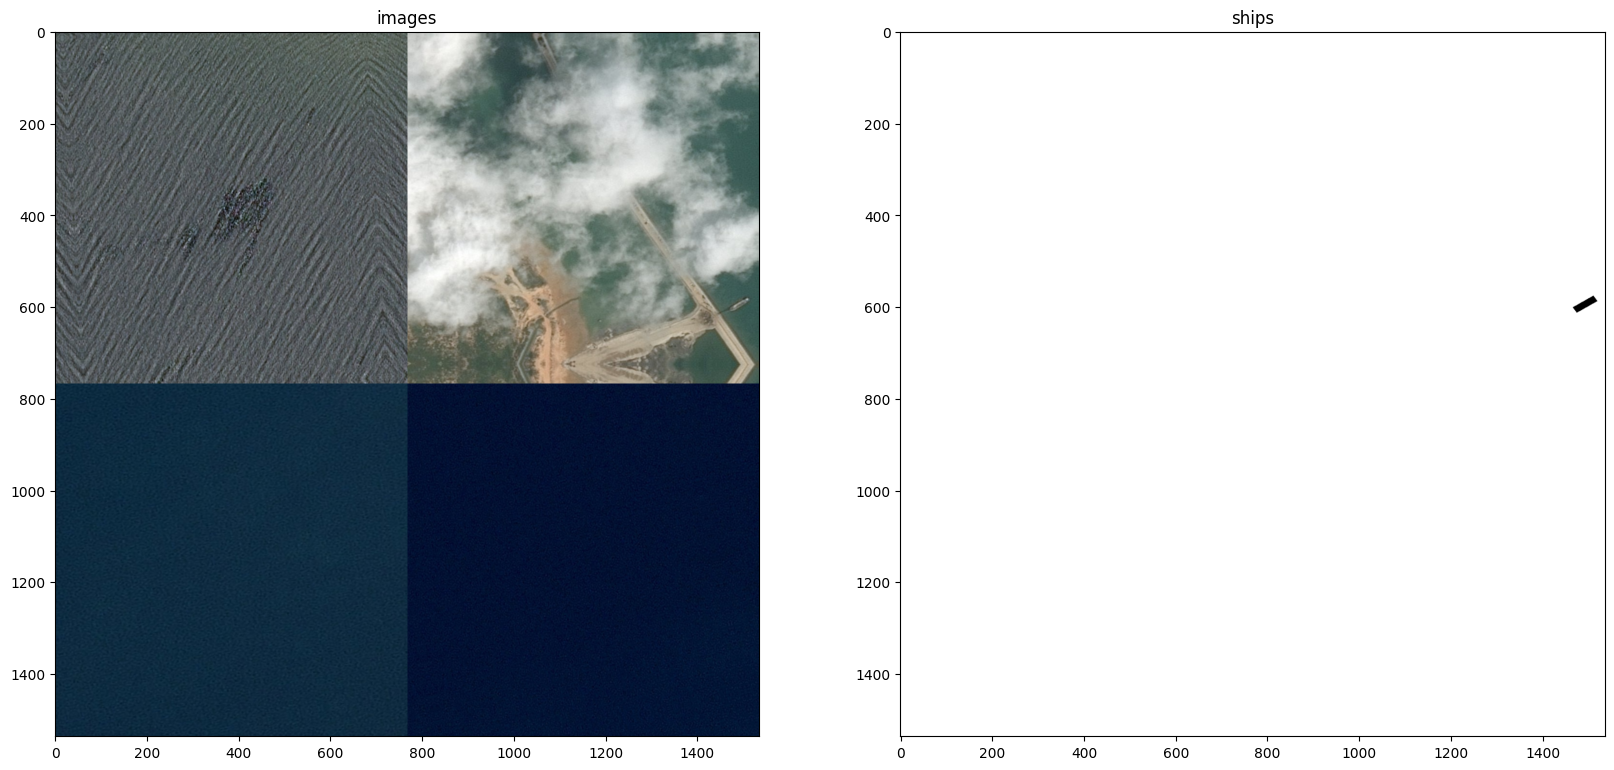

In [15]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

# Use balanced part of all dataset

500 images with no ships, 1500 images on each of 7 groups of ships quantity.

Metric did not increase than 0.3. 

Let will use all dataset without empty images (without ships). 

### First simple model

Deconvolution with UpSample2d

The best dice coefficient on a validation set is 0.3083

Choose type of upsampling layers in the model:

In [ ]:
from keras import models, layers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

Create model:

In [20]:
if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 gaussian_noise (GaussianNo  (None, 768, 768, 3)          0         ['RGB_Input[0][0]']           
 ise)                                                                                             
                                                                                                  
 batch_normalization (Batch  (None, 768, 768, 3)          12        ['gaussian_noise[0][0]']      
 Normalization)                                                                                   
                                                                                              

Create metrics:

In [39]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

Create checkpoint, reduce on plat and early stopping callbacks

In [40]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

Fit the model

In [43]:
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=(valid_x, valid_y.astype(np.float32)),
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: -0.0279 - dice_coef: 0.0283 - binary_accuracy: 0.8000 - true_positive_rate: 0.2674
Epoch 1: val_dice_coef improved from -inf to 0.11769, saving model to seg_model_weights.best.hdf5
200/200 [==============================] - 183s 920ms/step - loss: -0.0279 - dice_coef: 0.0283 - binary_accuracy: 0.8000 - true_positive_rate: 0.2674 - val_loss: -0.1186 - val_dice_coef: 0.1177 - val_binary_accuracy: 0.6360 - val_true_positive_rate: 0.7990 - lr: 1.0000e-04
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: -0.1466 - dice_coef: 0.1469 - binary_accuracy: 0.8419 - true_positive_rate: 0.2972
Epoch 2: val_dice_coef improved from 0.11769 to 0.19527, saving model to seg_model_weights.best.hdf5
200/200 [==============================] - 154s 775ms/step - loss: -0.1466 - dice_coef: 0.1469 - binary_accuracy: 0.8419 - true_positive_rate: 0.2972 - val_loss: -0.1931 - val_dice_coef: 0.1953 - val_binary_accuracy: 0.74

See the results:

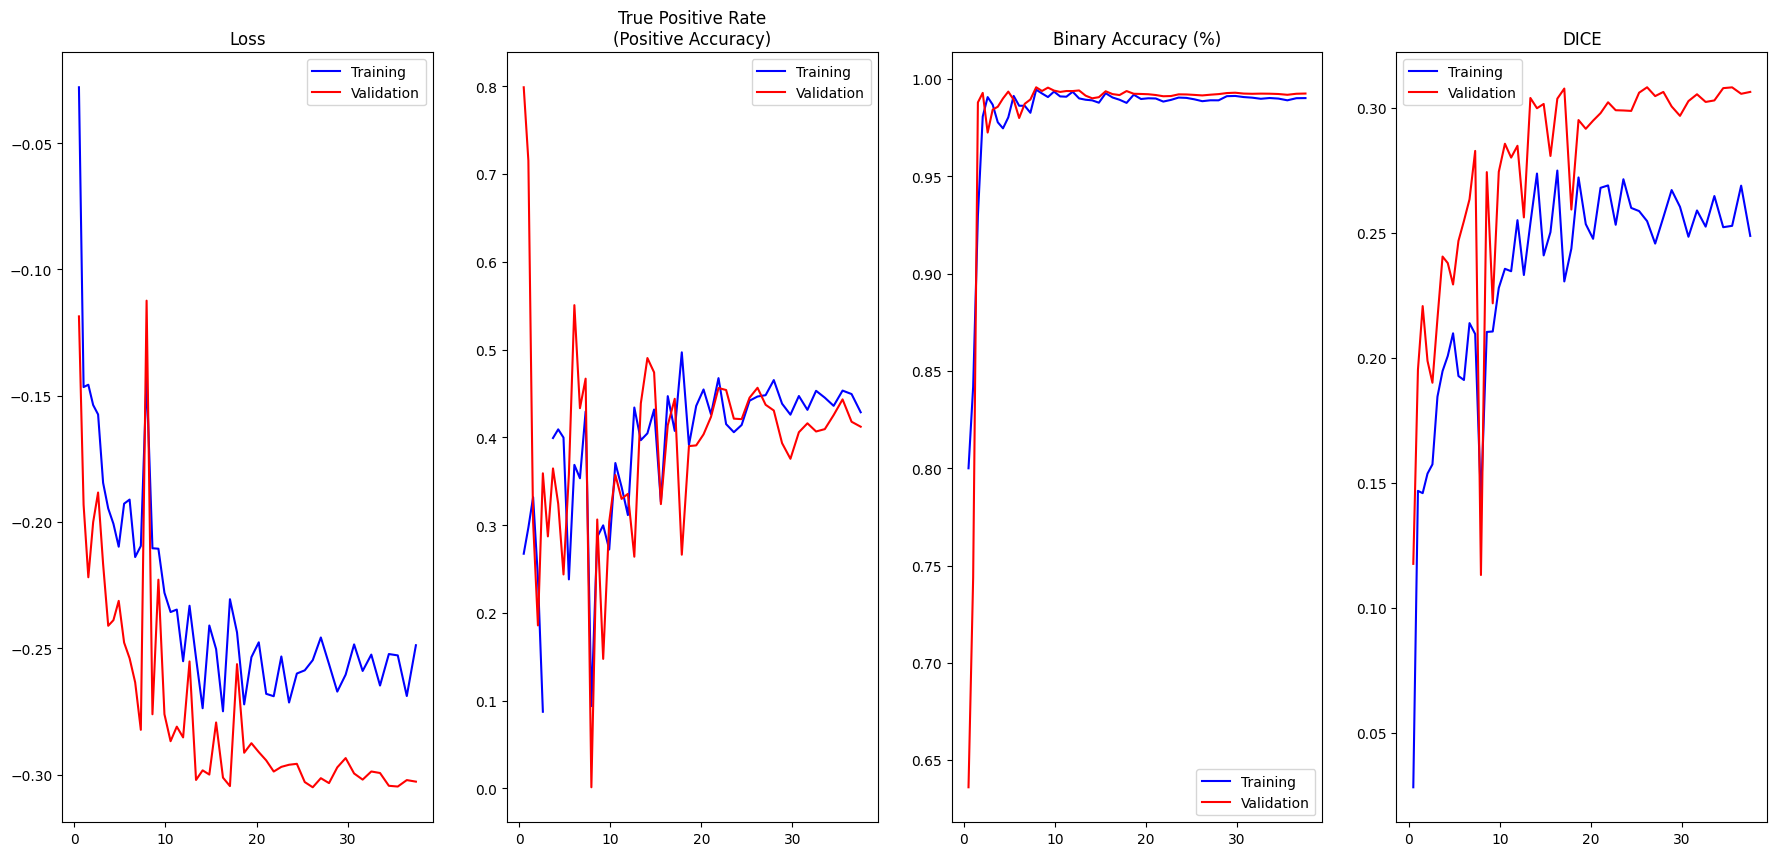

In [44]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

### Second model


Deconvolution with Conv2dTranspose

The best dice coefficient on a validation set is 0.109


In [27]:
if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model_2 = models.Model(inputs=[input_img], outputs=[d])
seg_model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 gaussian_noise_1 (Gaussian  (None, 768, 768, 3)          0         ['RGB_Input[0][0]']           
 Noise)                                                                                           
                                                                                                  
 batch_normalization_1 (Bat  (None, 768, 768, 3)          12        ['gaussian_noise_1[0][0]']    
 chNormalization)                                                                                 
                                                                                            

In [28]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model_2.compile(optimizer=Adam(1e-4), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [29]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model_2')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [30]:
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model_2.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=(valid_x, valid_y.astype(np.float32)),
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: -0.0053 - dice_coef: 0.0060 - binary_accuracy: 0.5244 - true_positive_rate: 0.5470
Epoch 1: val_dice_coef improved from -inf to 0.01014, saving model to seg_model_2_weights.best.hdf5
200/200 [==============================] - 188s 901ms/step - loss: -0.0053 - dice_coef: 0.0060 - binary_accuracy: 0.5244 - true_positive_rate: 0.5470 - val_loss: -0.0096 - val_dice_coef: 0.0101 - val_binary_accuracy: 0.9239 - val_true_positive_rate: 0.5756 - lr: 1.0000e-04
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: -0.0526 - dice_coef: 0.0531 - binary_accuracy: 0.8980 - true_positive_rate: 0.4231
Epoch 2: val_dice_coef improved from 0.01014 to 0.10949, saving model to seg_model_2_weights.best.hdf5
200/200 [==============================] - 155s 778ms/step - loss: -0.0526 - dice_coef: 0.0531 - binary_accuracy: 0.8980 - true_positive_rate: 0.4231 - val_loss: -0.1137 - val_dice_coef: 0.1095 - val_binary_accuracy: 

KeyboardInterrupt: 

In [ ]:
gc.collect()

In [ ]:
# seg_model.load_weights(weight_path)
seg_model_2.save('seg_model_2.h5')

pred_y = seg_model_2.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log')

### Third model

Deconvolution with UpSample2d. 

Use downsampling inside the network with AvgPooling2d 

The best dice coefficient on a validation set is 0.1498

In [21]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 50
GAUSSIAN_NOISE = 0.1
# UPSAMPLE_MODE = 'DECONV'
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = True
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 1000
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [22]:
if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model_2 = models.Model(inputs=[input_img], outputs=[d])
seg_model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 average_pooling2d (Average  (None, 768, 768, 3)          0         ['RGB_Input[0][0]']           
 Pooling2D)                                                                                       
                                                                                                  
 gaussian_noise (GaussianNo  (None, 768, 768, 3)          0         ['average_pooling2d[0][0]']   
 ise)                                                                                             
                                                                                              

In [23]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model_2.compile(optimizer=Adam(1e-4), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [24]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model_2')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [26]:
gc.collect()

0

In [27]:
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model_2.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=(valid_x, valid_y.astype(np.float32)),
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]

/tmp/ipykernel_47/212627362.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = [seg_model_2.fit_generator(aug_gen,


Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: -0.0713 - dice_coef: 0.0717 - binary_accuracy: 0.8635 - true_positive_rate: 0.2533
Epoch 1: val_dice_coef improved from -inf to 0.14243, saving model to seg_model_2_weights.best.hdf5
200/200 [==============================] - 203s 919ms/step - loss: -0.0713 - dice_coef: 0.0717 - binary_accuracy: 0.8635 - true_positive_rate: 0.2533 - val_loss: -0.1415 - val_dice_coef: 0.1424 - val_binary_accuracy: 0.6252 - val_true_positive_rate: 0.7751 - lr: 1.0000e-04
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: -0.1351 - dice_coef: 0.1360 - binary_accuracy: 0.7571 - true_positive_rate: 0.4842
Epoch 2: val_dice_coef did not improve from 0.14243
200/200 [==============================] - 152s 761ms/step - loss: -0.1351 - dice_coef: 0.1360 - binary_accuracy: 0.7571 - true_positive_rate: 0.4842 - val_loss: -0.0421 - val_dice_coef: 0.0429 - val_binary_accuracy: 0.6143 - val_true_positive_rate: 0.9185 - lr: 1.000

KeyboardInterrupt: 

In [ ]:
# seg_model.load_weights(weight_path)
seg_model_2.save('seg_model_2.h5')

pred_y = seg_model_2.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log')

### Fourth model

Deconvolution with UpSample2d. 

Change kernel sizes

The best dice coefficient on a validation set is under 0.25

In [21]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 50
GAUSSIAN_NOISE = 0.1
# UPSAMPLE_MODE = 'DECONV'
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 500
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [22]:
if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (16, 16), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (16, 16), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model_2 = models.Model(inputs=[input_img], outputs=[d])
seg_model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 gaussian_noise_1 (Gaussian  (None, 768, 768, 3)          0         ['RGB_Input[0][0]']           
 Noise)                                                                                           
                                                                                                  
 batch_normalization_1 (Bat  (None, 768, 768, 3)          12        ['gaussian_noise_1[0][0]']    
 chNormalization)                                                                                 
                                                                                            

In [23]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model_2.compile(optimizer=Adam(1e-4), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [24]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model_2')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [25]:
gc.collect()

543

In [26]:
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model_2.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=(valid_x, valid_y.astype(np.float32)),
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]

/tmp/ipykernel_47/212627362.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = [seg_model_2.fit_generator(aug_gen,


Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: -0.1291 - dice_coef: 0.1306 - binary_accuracy: 0.6590 - true_positive_rate: 0.6640
Epoch 1: val_dice_coef improved from -inf to 0.20473, saving model to seg_model_2_weights.best.hdf5
200/200 [==============================] - 234s 1s/step - loss: -0.1291 - dice_coef: 0.1306 - binary_accuracy: 0.6590 - true_positive_rate: 0.6640 - val_loss: -0.2080 - val_dice_coef: 0.2047 - val_binary_accuracy: 0.9966 - val_true_positive_rate: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: -0.2739 - dice_coef: 0.2739 - binary_accuracy: 0.9967 - true_positive_rate: nan
Epoch 2: val_dice_coef improved from 0.20473 to 0.24856, saving model to seg_model_2_weights.best.hdf5
200/200 [==============================] - 166s 830ms/step - loss: -0.2739 - dice_coef: 0.2739 - binary_accuracy: 0.9967 - true_positive_rate: nan - val_loss: -0.2483 - val_dice_coef: 0.2486 - val_binary_accuracy: 0.996

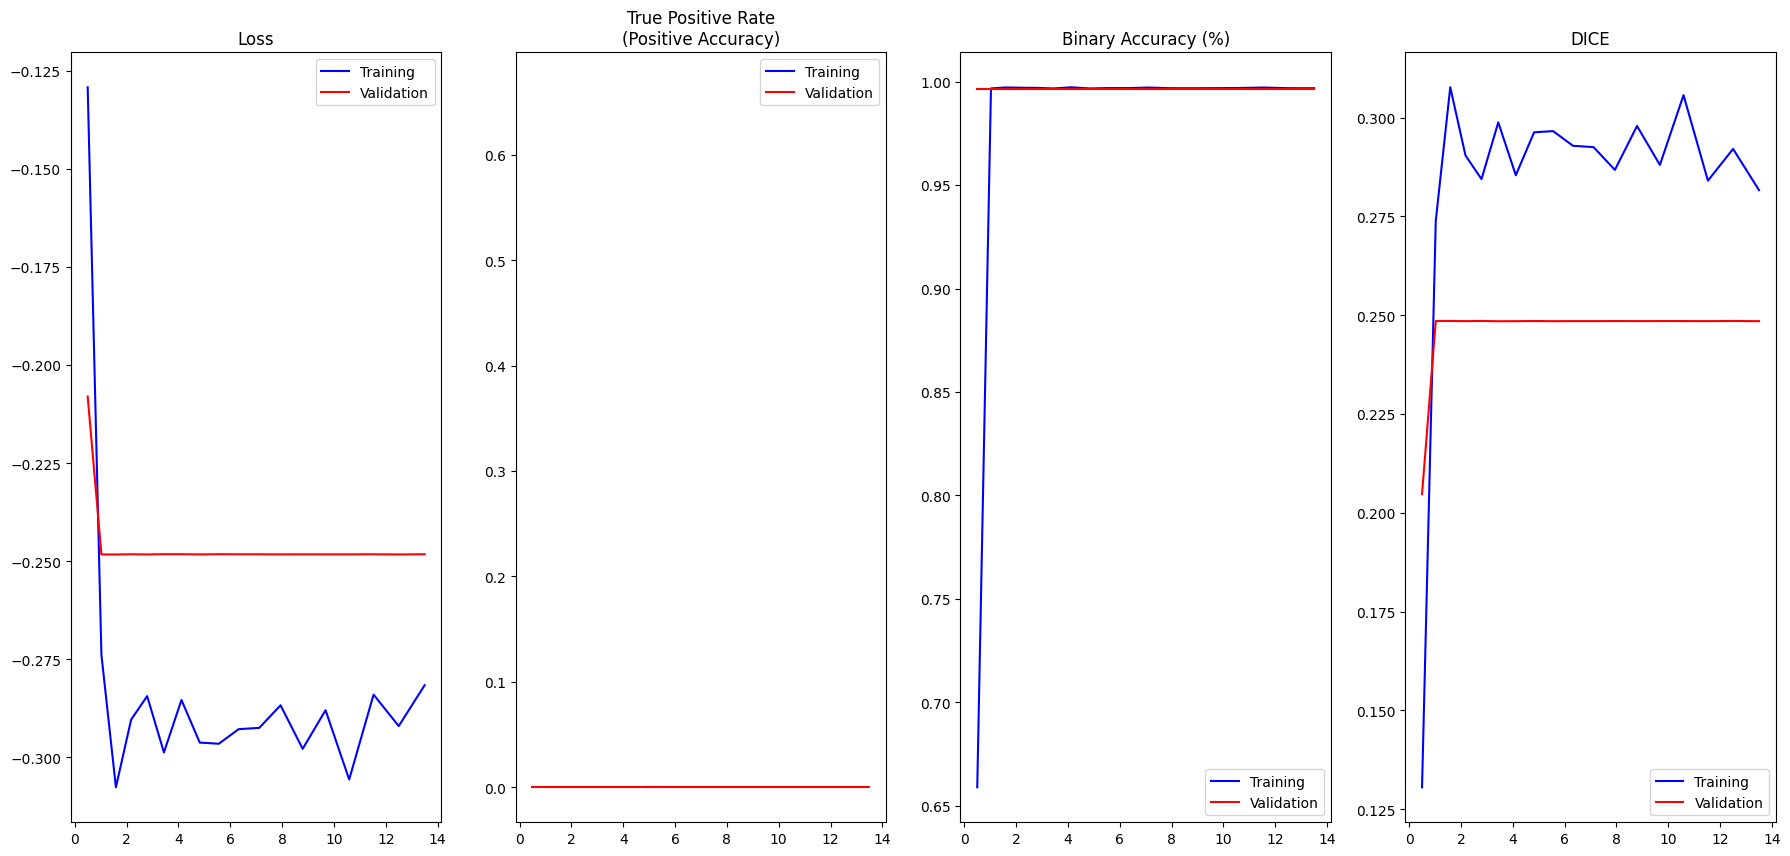

In [27]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

### Fifth model

Deconvolution with UpSample2d. 

Change kernel sizes

The best dice coefficient on a validation set is under 0.25

In [21]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 50
GAUSSIAN_NOISE = 0.1
# UPSAMPLE_MODE = 'DECONV'
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 500
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [28]:
if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (16, 16), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (16, 16), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (16, 16), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (16, 16), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model_2 = models.Model(inputs=[input_img], outputs=[d])
seg_model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 gaussian_noise_2 (Gaussian  (None, 768, 768, 3)          0         ['RGB_Input[0][0]']           
 Noise)                                                                                           
                                                                                                  
 batch_normalization_2 (Bat  (None, 768, 768, 3)          12        ['gaussian_noise_2[0][0]']    
 chNormalization)                                                                                 
                                                                                            

In [29]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model_2.compile(optimizer=Adam(1e-4), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [30]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model_2')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [31]:
gc.collect()

16818

In [ ]:
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model_2.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=(valid_x, valid_y.astype(np.float32)),
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]

/tmp/ipykernel_47/212627362.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = [seg_model_2.fit_generator(aug_gen,


Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: -0.1543 - dice_coef: 0.1548 - binary_accuracy: 0.7402 - true_positive_rate: nan
Epoch 1: val_dice_coef improved from -inf to 0.24857, saving model to seg_model_2_weights.best.hdf5
200/200 [==============================] - 303s 1s/step - loss: -0.1543 - dice_coef: 0.1548 - binary_accuracy: 0.7402 - true_positive_rate: nan - val_loss: -0.2483 - val_dice_coef: 0.2486 - val_binary_accuracy: 0.9966 - val_true_positive_rate: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: -0.2834 - dice_coef: 0.2835 - binary_accuracy: 0.9967 - true_positive_rate: 0.0000e+00
Epoch 2: val_dice_coef did not improve from 0.24857
200/200 [==============================] - 225s 1s/step - loss: -0.2834 - dice_coef: 0.2835 - binary_accuracy: 0.9967 - true_positive_rate: 0.0000e+00 - val_loss: -0.2482 - val_dice_coef: 0.2485 - val_binary_accuracy: 0.9966 - val_true_positive_rate: 0.0000e+00 - lr: 1

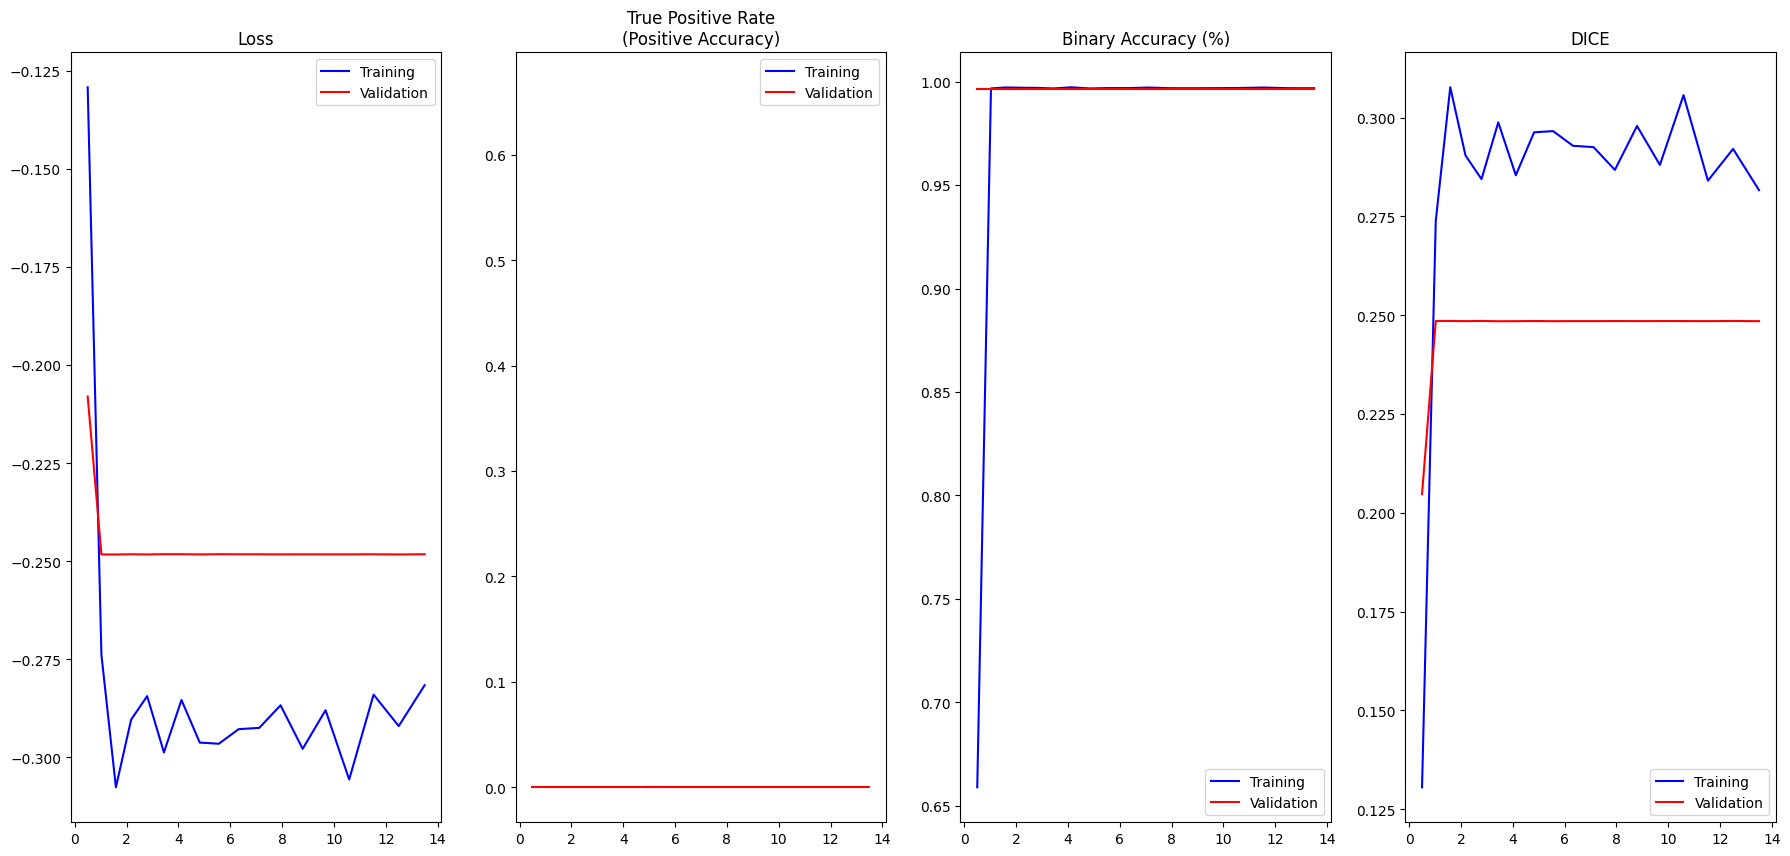

In [27]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

# Use only ship-include images and all dataset

The current neural network must perform two tasks: classification (there are or are not ships in the photo) and segmentation, if any. You can break these tasks down: one neural network predicts whether there are ships in the photo. And the other segments. Presumably, a network trained only on pictures of ships will have greater accuracy.

Size of whole dataset

In [27]:
train_df.shape, valid_df.shape

((161048, 7), (69034, 7))

choose only images with ships

In [6]:
train_df = train_df[train_df['ships'] != 0]
valid_df = valid_df[valid_df['ships'] != 0]
train_df.shape, valid_df.shape

((56543, 6), (24246, 6))

create generator

In [7]:
train_gen = make_image_gen(train_df, 4) # create a generator

# see an example of batch:
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


create valid generator

In [8]:
valid_gen = make_image_gen(valid_df, VALID_IMG_COUNT)

# see an example of batch:
valid_x, valid_y = next(valid_gen)
print(valid_x.shape, valid_y.shape)

(500, 768, 768, 3) (500, 768, 768, 1)


In [11]:
gc.collect()

0

In [9]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (4, 768, 768, 3) float32 0.0 1.0
y (4, 768, 768, 1) float32 0.0 1.0


Text(0.5, 1.0, 'ships')

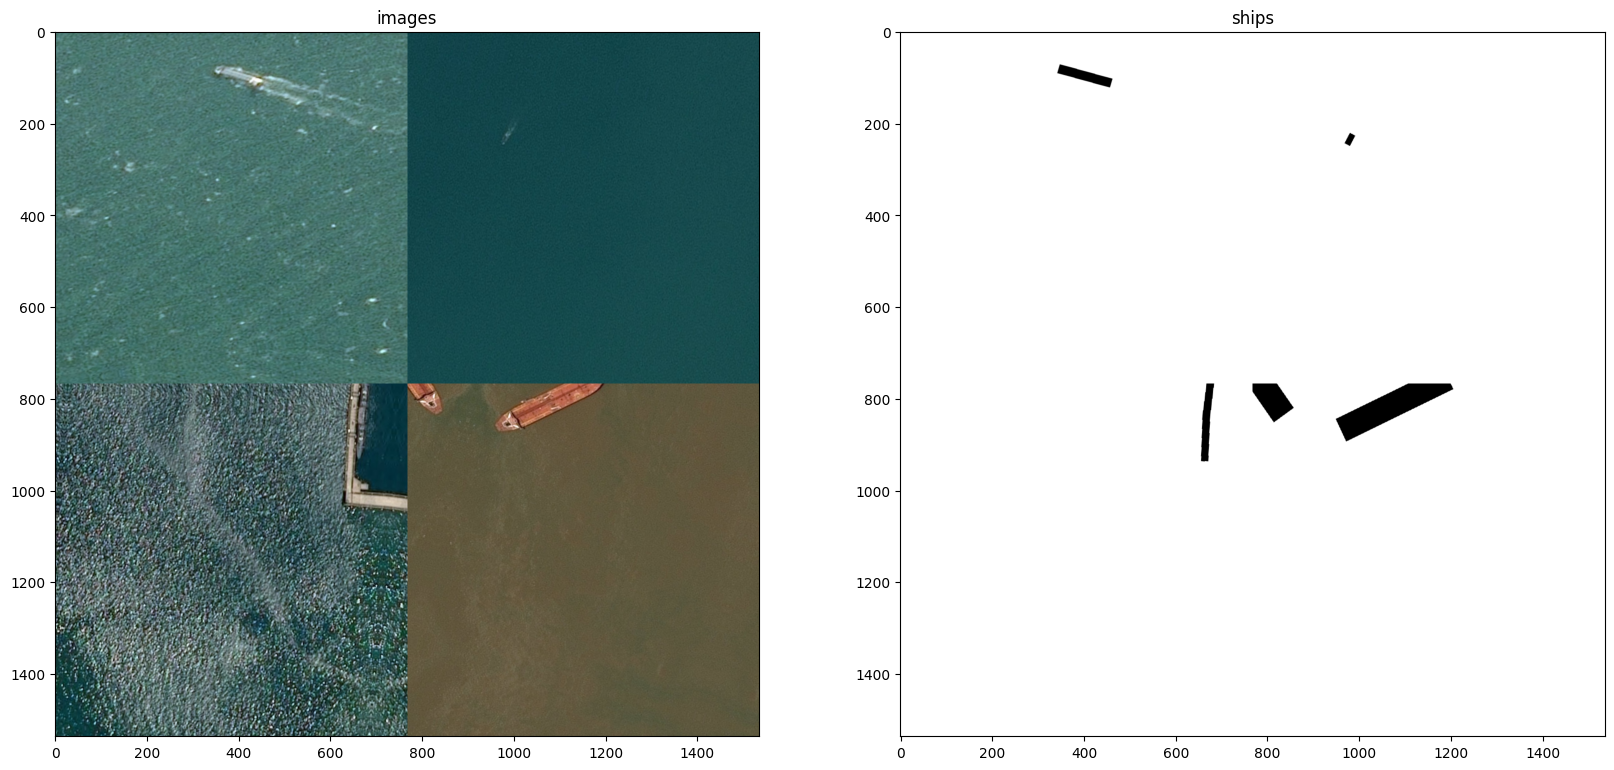

In [10]:
# take an augmentation
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

### First simple model

Deconvolution with Conv2DTranspose

we take an overfitting.

The best dice coefficient on a validation set is 0.3491

In [19]:
gc.collect()

1934

In [12]:
BATCH_SIZE = 2
EDGE_CROP = 16
NB_EPOCHS = 30
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
# VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [ ]:
from keras import models, layers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

In [14]:
if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model_all = models.Model(inputs=[input_img], outputs=[d])
seg_model_all.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 gaussian_noise (GaussianNo  (None, 768, 768, 3)          0         ['RGB_Input[0][0]']           
 ise)                                                                                             
                                                                                                  
 batch_normalization (Batch  (None, 768, 768, 3)          12        ['gaussian_noise[0][0]']      
 Normalization)                                                                                   
                                                                                              

In [15]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

# compile of model
seg_model_all.compile(optimizer=Adam(1e-4), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [16]:
gc.collect()

684

In [17]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# weight_path="{}_model.best.h5".format('seg_model_all')
path = f'/kaggle/working/model_all_2.h5'

checkpoint = ModelCheckpoint(filepath=path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False, save_format="tf")

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [18]:
step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(train_df))
loss_history = [seg_model_all.fit(aug_gen, 
                                  steps_per_epoch=step_count, 
                                  epochs=NB_EPOCHS, 
                                  validation_data=(valid_x, valid_y.astype(np.float32)),
                                  callbacks=callbacks_list,
                                  workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: -0.0510 - dice_coef: 0.0515 - binary_accuracy: 0.8982 - true_positive_rate: 0.1897
Epoch 1: val_dice_coef improved from -inf to 0.13400, saving model to /kaggle/working/model_all_2.h5
200/200 [==============================] - 204s 910ms/step - loss: -0.0510 - dice_coef: 0.0515 - binary_accuracy: 0.8982 - true_positive_rate: 0.1897 - val_loss: -0.1320 - val_dice_coef: 0.1340 - val_binary_accuracy: 0.6069 - val_true_positive_rate: 0.7862 - lr: 1.0000e-04
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - ETA: 0s - loss: -0.1906 - dice_coef: 0.1920 - binary_accuracy: 0.6891 - true_positive_rate: 0.6833
Epoch 2: val_dice_coef improved from 0.13400 to 0.19810, saving model to /kaggle/working/model_all_2.h5
200/200 [==============================] - 153s 769ms/step - loss: -0.1906 - dice_coef: 0.1920 - binary_accuracy: 0.6891 - true_positive_rate: 0.6833 - val_loss: -0.1959 - val_dice_coef: 0.1981 - val_binary_accuracy: 0.6844 - val_true_positive_rate: 0.6736 - lr: 1.0000e-04
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: -0.2571 - dice_coef: 0.2584 - binary_accuracy: 0.8190 - true_positive_rate: 0.6302
Epoch 3: val_dice_coef improved from 0.19810 to 0.23248, saving model to /kaggle/working/model_all_2.h5
200/200 [==============================] - 149s 746ms/step - loss: -0.2571 - dice_coef: 0.2584 - binary_accuracy: 0.8190 - true_positive_rate: 0.6302 - val_loss: -0.2299 - val_dice_coef: 0.2325 - val_binary_accuracy: 0.6954

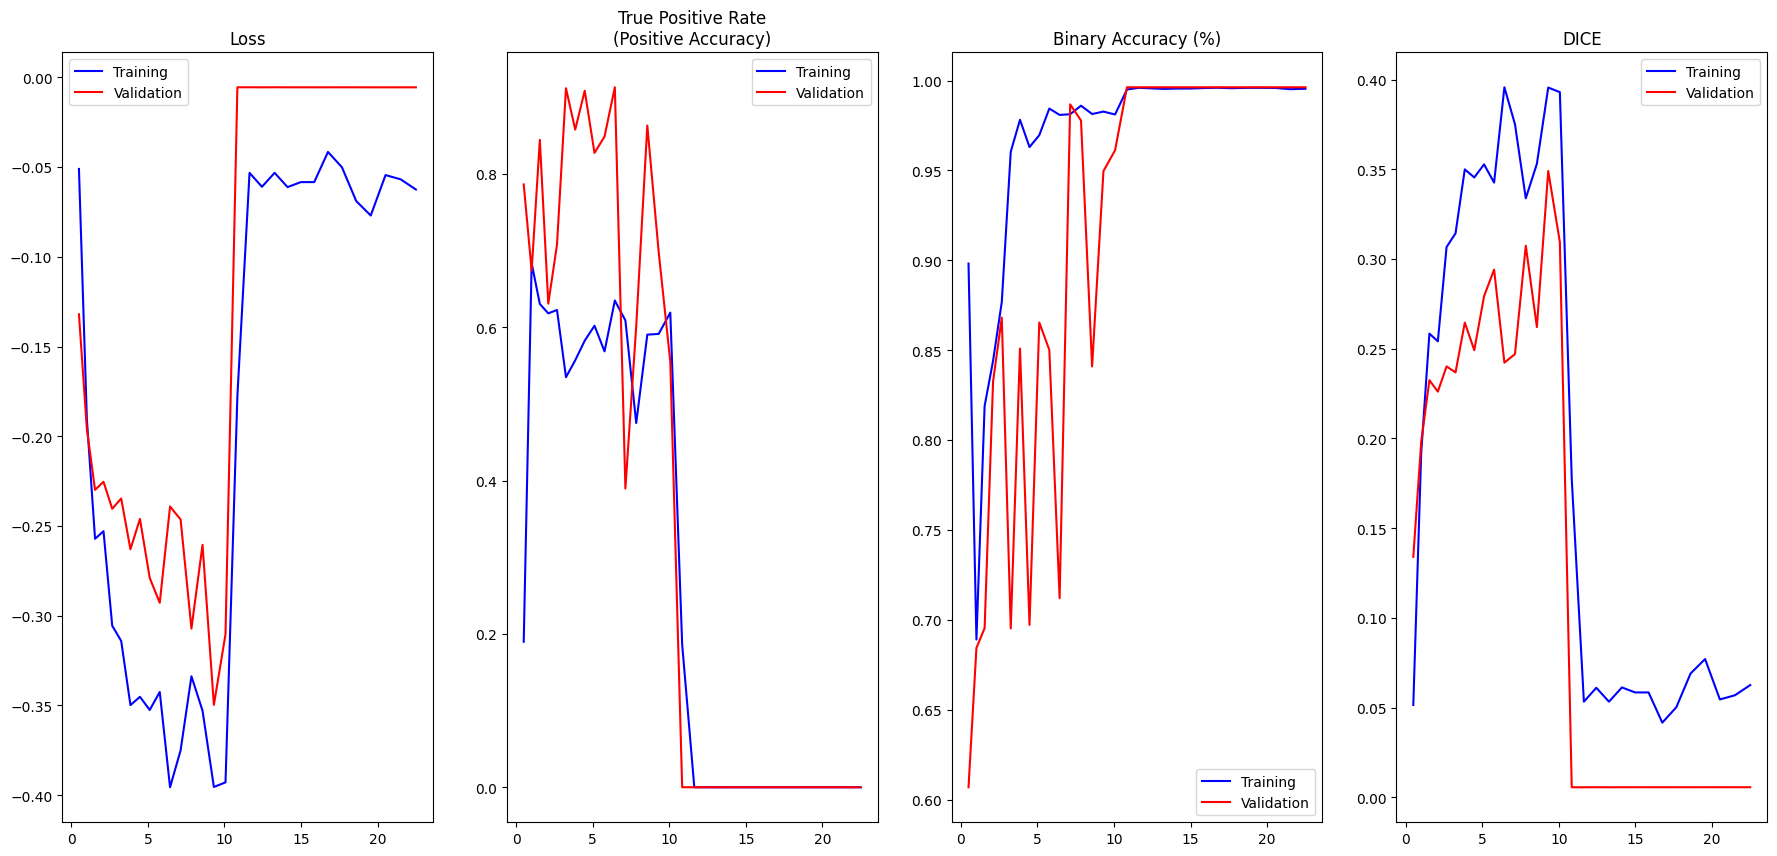

In [19]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [ ]:
# seg_model.load_weights(weight_path)
# seg_model_all.save('seg_model_2.h5')

valid_x, valid_y = next(valid_gen)

pred_y = seg_model_all.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log')

In [ ]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('fullres_model.h5')

### Second simple model

Deconvolution with ConvTranspose

Add a average scaling before convolutional layers.

The best dice coefficient on a validation set is 0.4198

In [19]:
gc.collect()

1934

In [14]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 30
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = True
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
# VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [15]:
if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model_all = models.Model(inputs=[input_img], outputs=[d])
seg_model_all.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 average_pooling2d (Average  (None, 768, 768, 3)          0         ['RGB_Input[0][0]']           
 Pooling2D)                                                                                       
                                                                                                  
 gaussian_noise (GaussianNo  (None, 768, 768, 3)          0         ['average_pooling2d[0][0]']   
 ise)                                                                                             
                                                                                              

In [16]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

# compile of model
seg_model_all.compile(optimizer=Adam(1e-4), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [16]:
gc.collect()

175

In [17]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# weight_path="{}_model.best.h5".format('seg_model_all')
path = f'/kaggle/working/model_all_2.h5'

checkpoint = ModelCheckpoint(filepath=path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False, save_format="tf")

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [18]:
step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(train_df))
loss_history = [seg_model_all.fit(aug_gen, 
                                  steps_per_epoch=step_count, 
                                  epochs=NB_EPOCHS, 
                                  validation_data=(valid_x, valid_y.astype(np.float32)),
                                  callbacks=callbacks_list,
                                  workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: -0.0330 - dice_coef: 0.0336 - binary_accuracy: 0.4940 - true_positive_rate: 0.7305
Epoch 1: val_dice_coef improved from -inf to 0.06811, saving model to /kaggle/working/model_all_2.h5
200/200 [==============================] - 199s 886ms/step - loss: -0.0330 - dice_coef: 0.0336 - binary_accuracy: 0.4940 - true_positive_rate: 0.7305 - val_loss: -0.0673 - val_dice_coef: 0.0681 - val_binary_accuracy: 0.6470 - val_true_positive_rate: 0.7255 - lr: 1.0000e-04
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - ETA: 0s - loss: -0.2158 - dice_coef: 0.2175 - binary_accuracy: 0.7320 - true_positive_rate: 0.6450
Epoch 2: val_dice_coef improved from 0.06811 to 0.17862, saving model to /kaggle/working/model_all_2.h5
200/200 [==============================] - 143s 719ms/step - loss: -0.2158 - dice_coef: 0.2175 - binary_accuracy: 0.7320 - true_positive_rate: 0.6450 - val_loss: -0.1769 - val_dice_coef: 0.1786 - val_binary_accuracy: 0.6481 - val_true_positive_rate: 0.8455 - lr: 1.0000e-04
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: -0.2703 - dice_coef: 0.2714 - binary_accuracy: 0.7796 - true_positive_rate: 0.6811
Epoch 3: val_dice_coef improved from 0.17862 to 0.25567, saving model to /kaggle/working/model_all_2.h5
200/200 [==============================] - 142s 711ms/step - loss: -0.2703 - dice_coef: 0.2714 - binary_accuracy: 0.7796 - true_positive_rate: 0.6811 - val_loss: -0.2546 - val_dice_coef: 0.2557 - val_binary_accuracy: 0.6751

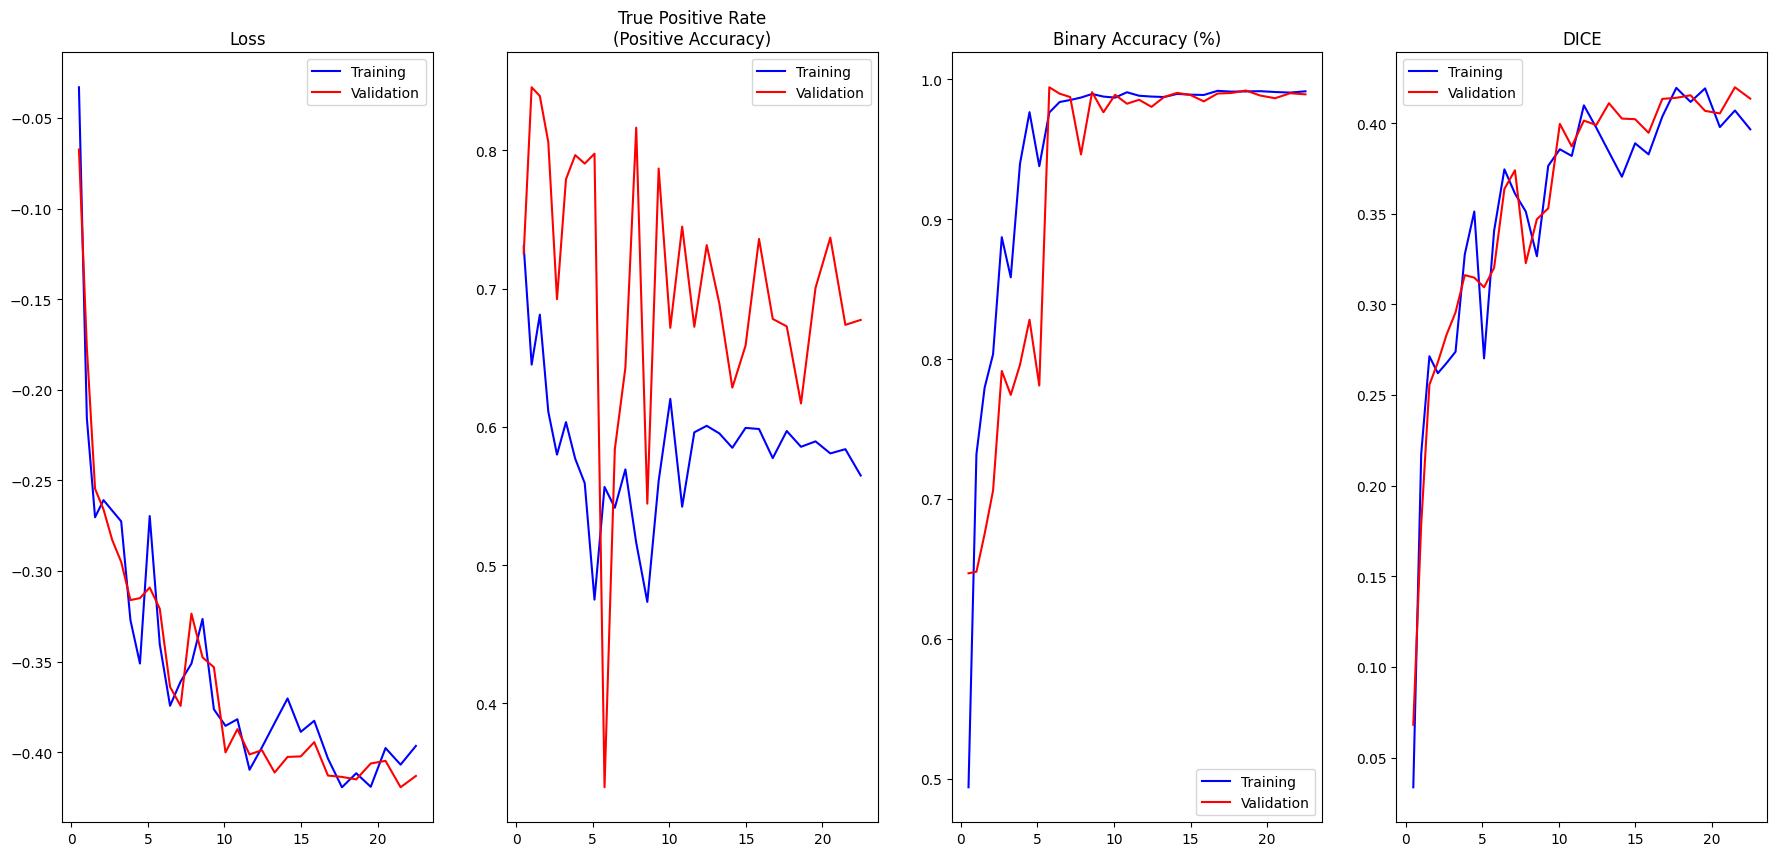

In [19]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [ ]:
# seg_model.load_weights(weight_path)
# seg_model_all.save('seg_model_2.h5')

valid_x, valid_y = next(valid_gen)

pred_y = seg_model_all.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log')

### Third model

Deconvolution with ConvTranspose

Add a average scaling before convolutional layers.

plus increase gaussian blur

The best dice coefficient on a validation set is 0.2964

Then will reset gaussian blur and change kernel


In [19]:
gc.collect()

1934

In [12]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 40
GAUSSIAN_NOISE = 0.5
UPSAMPLE_MODE = 'DECONV'
# UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = True
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
# VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [13]:
if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model_all = models.Model(inputs=[input_img], outputs=[d])
seg_model_all.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 average_pooling2d (Average  (None, 768, 768, 3)          0         ['RGB_Input[0][0]']           
 Pooling2D)                                                                                       
                                                                                                  
 gaussian_noise (GaussianNo  (None, 768, 768, 3)          0         ['average_pooling2d[0][0]']   
 ise)                                                                                             
                                                                                              

In [14]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

# compile of model
seg_model_all.compile(optimizer=Adam(1e-4), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [15]:
gc.collect()

215

In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# weight_path="{}_model.best.h5".format('seg_model_all')
path = f'/kaggle/working/model_all_3.h5'

checkpoint = ModelCheckpoint(filepath=path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False, save_format="tf")

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [17]:
step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(train_df))
loss_history = [seg_model_all.fit(aug_gen, 
                                  steps_per_epoch=step_count, 
                                  epochs=NB_EPOCHS, 
                                  validation_data=(valid_x, valid_y.astype(np.float32)),
                                  callbacks=callbacks_list,
                                  workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/40
200/200 [==============================] - ETA: 0s - loss: -0.0266 - dice_coef: 0.0271 - binary_accuracy: 0.7185 - true_positive_rate: 0.3896
Epoch 1: val_dice_coef improved from -inf to 0.08521, saving model to /kaggle/working/model_all_3.h5
200/200 [==============================] - 195s 862ms/step - loss: -0.0266 - dice_coef: 0.0271 - binary_accuracy: 0.7185 - true_positive_rate: 0.3896 - val_loss: -0.0853 - val_dice_coef: 0.0852 - val_binary_accuracy: 0.6574 - val_true_positive_rate: 0.5898 - lr: 1.0000e-04
Epoch 2/40


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - ETA: 0s - loss: -0.1754 - dice_coef: 0.1761 - binary_accuracy: 0.7463 - true_positive_rate: 0.5762
Epoch 2: val_dice_coef improved from 0.08521 to 0.20819, saving model to /kaggle/working/model_all_3.h5
200/200 [==============================] - 142s 715ms/step - loss: -0.1754 - dice_coef: 0.1761 - binary_accuracy: 0.7463 - true_positive_rate: 0.5762 - val_loss: -0.2073 - val_dice_coef: 0.2082 - val_binary_accuracy: 0.6875 - val_true_positive_rate: 0.7428 - lr: 1.0000e-04
Epoch 3/40
200/200 [==============================] - ETA: 0s - loss: -0.2308 - dice_coef: 0.2311 - binary_accuracy: 0.9369 - true_positive_rate: 0.4180
Epoch 3: val_dice_coef improved from 0.20819 to 0.22966, saving model to /kaggle/working/model_all_3.h5
200/200 [==============================] - 140s 704ms/step - loss: -0.2308 - dice_coef: 0.2311 - binary_accuracy: 0.9369 - true_positive_rate: 0.4180 - val_loss: -0.2298 - val_dice_coef: 0.2297 - val_binary_accuracy: 0.9896

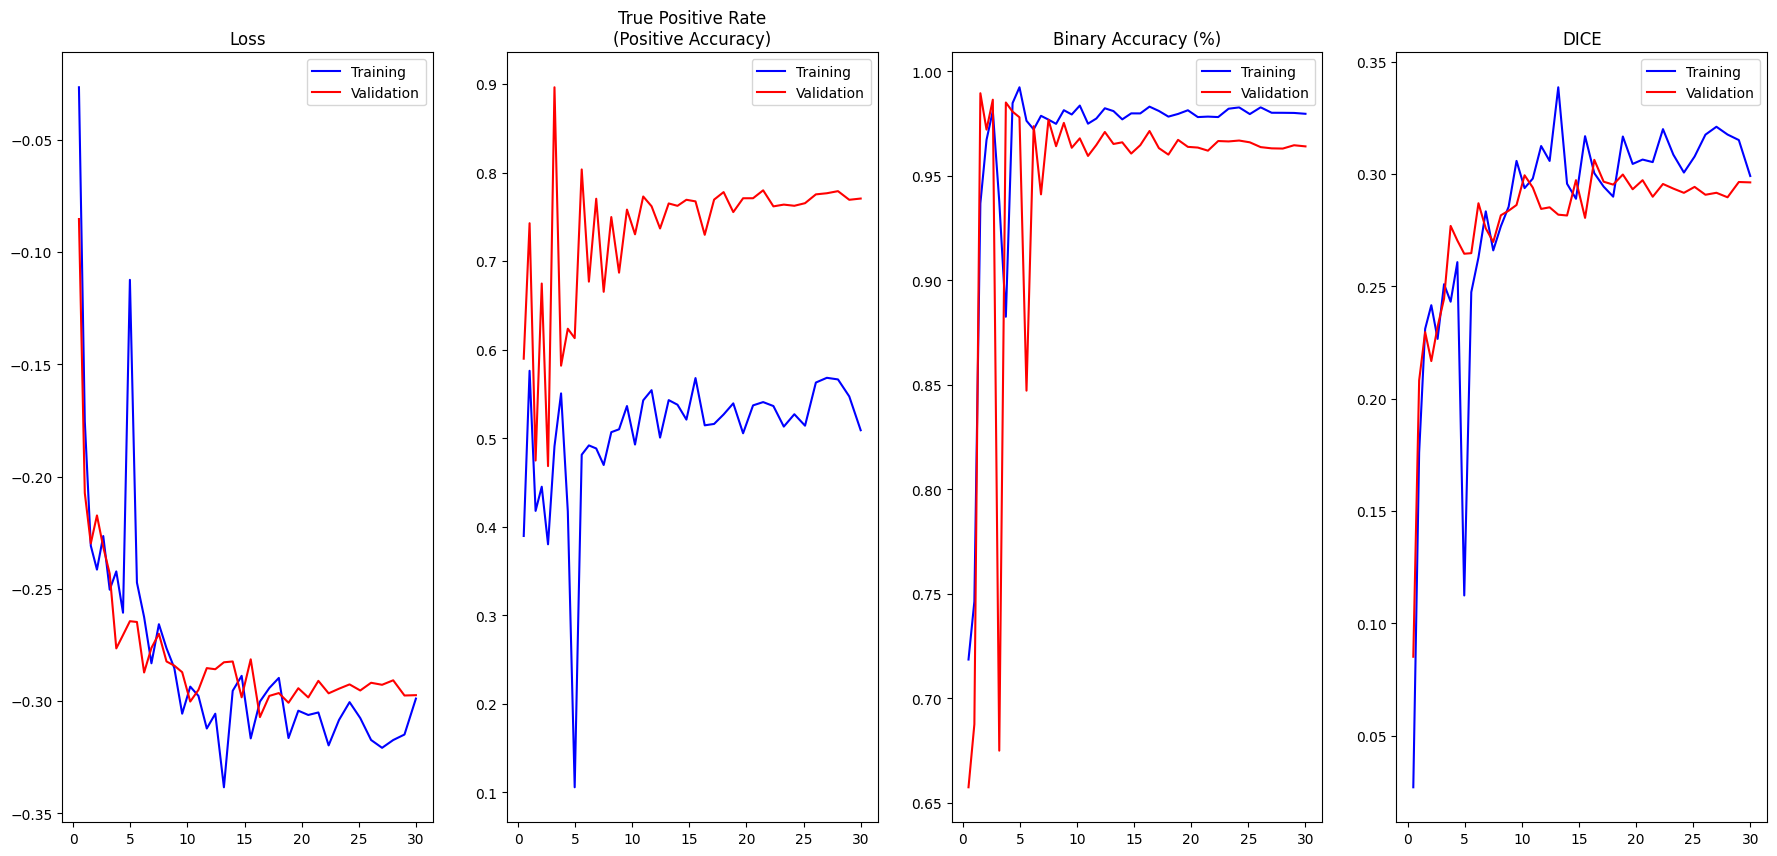

In [18]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [ ]:
# seg_model.load_weights(weight_path)
# seg_model_all.save('seg_model_2.h5')

valid_x, valid_y = next(valid_gen)

pred_y = seg_model_all.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log')

### Fourth model

Deconvolution with ConvTranspose

Add a average scaling before convolutional layers.

change kernels in conv layers

The best dice coefficient on a validation set is 0.38



In [15]:
gc.collect()

40

In [16]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 40
GAUSSIAN_NOISE = 0.5
UPSAMPLE_MODE = 'DECONV'
# UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = True
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
# VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [18]:
if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (32, 32), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (32, 32), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model_all = models.Model(inputs=[input_img], outputs=[d])
seg_model_all.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 average_pooling2d_1 (Avera  (None, 768, 768, 3)          0         ['RGB_Input[0][0]']           
 gePooling2D)                                                                                     
                                                                                                  
 gaussian_noise_1 (Gaussian  (None, 768, 768, 3)          0         ['average_pooling2d_1[0][0]'] 
 Noise)                                                                                           
                                                                                            

In [19]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

# compile of model
seg_model_all.compile(optimizer=Adam(1e-4), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [20]:
gc.collect()

3486

In [21]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# weight_path="{}_model.best.h5".format('seg_model_all')
path = f'/kaggle/working/model_all_4.h5'

checkpoint = ModelCheckpoint(filepath=path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False, save_format="tf")

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [22]:
step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(train_df))
loss_history = [seg_model_all.fit(aug_gen, 
                                  steps_per_epoch=step_count, 
                                  epochs=NB_EPOCHS, 
                                  validation_data=(valid_x, valid_y.astype(np.float32)),
                                  callbacks=callbacks_list,
                                  workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/40
200/200 [==============================] - ETA: 0s - loss: -0.1327 - dice_coef: 0.1346 - binary_accuracy: 0.7317 - true_positive_rate: 0.6016
Epoch 1: val_dice_coef improved from -inf to 0.16354, saving model to /kaggle/working/model_all_4.h5
200/200 [==============================] - 873s 4s/step - loss: -0.1327 - dice_coef: 0.1346 - binary_accuracy: 0.7317 - true_positive_rate: 0.6016 - val_loss: -0.1617 - val_dice_coef: 0.1635 - val_binary_accuracy: 0.9375 - val_true_positive_rate: 0.3165 - lr: 1.0000e-04
Epoch 2/40


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - ETA: 0s - loss: -0.2421 - dice_coef: 0.2426 - binary_accuracy: 0.9275 - true_positive_rate: 0.4977
Epoch 2: val_dice_coef improved from 0.16354 to 0.26516, saving model to /kaggle/working/model_all_4.h5
200/200 [==============================] - 558s 3s/step - loss: -0.2421 - dice_coef: 0.2426 - binary_accuracy: 0.9275 - true_positive_rate: 0.4977 - val_loss: -0.2646 - val_dice_coef: 0.2652 - val_binary_accuracy: 0.9056 - val_true_positive_rate: 0.6642 - lr: 1.0000e-04
Epoch 3/40
200/200 [==============================] - ETA: 0s - loss: -0.2443 - dice_coef: 0.2446 - binary_accuracy: 0.9656 - true_positive_rate: 0.4245
Epoch 3: val_dice_coef did not improve from 0.26516
200/200 [==============================] - 558s 3s/step - loss: -0.2443 - dice_coef: 0.2446 - binary_accuracy: 0.9656 - true_positive_rate: 0.4245 - val_loss: -0.2630 - val_dice_coef: 0.2635 - val_binary_accuracy: 0.9006 - val_true_positive_rate: 0.6854 - lr: 1.0000e-04
Epoch 4

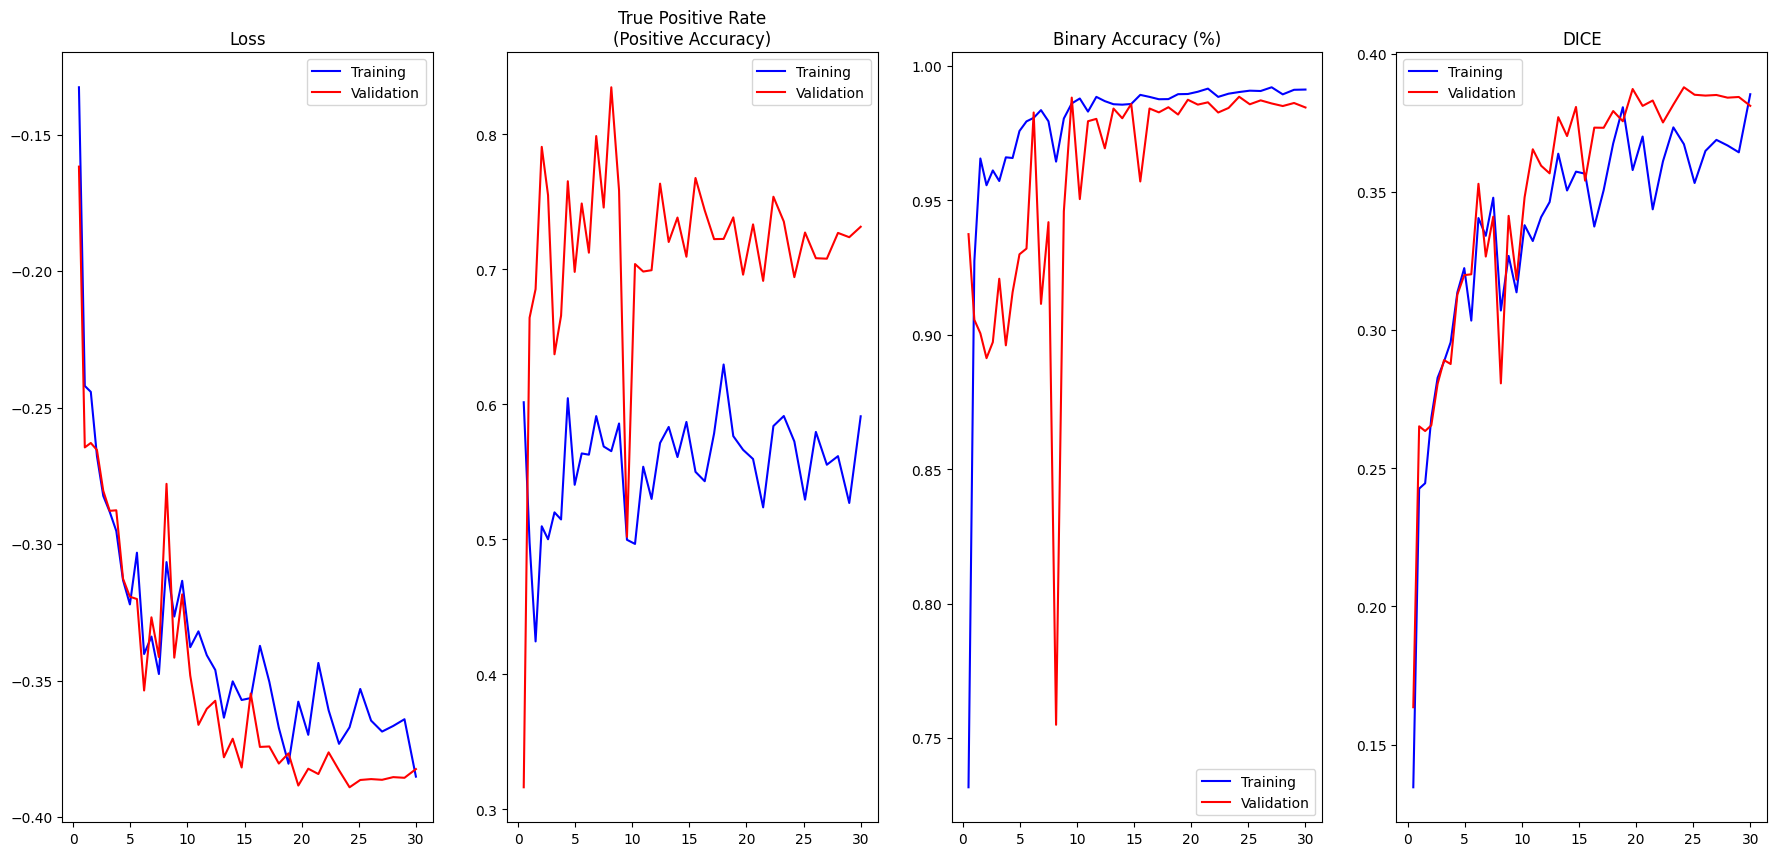

In [23]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [ ]:
# seg_model.load_weights(weight_path)
# seg_model_all.save('seg_model_2.h5')

valid_x, valid_y = next(valid_gen)

pred_y = seg_model_all.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log')

### Sixth model

Deconvolution with ConvTranspose

Add a average scaling before convolutional layers.

change number of neurons in conv layers

The best dice coefficient on a validation set is 0.38



In [15]:
gc.collect()

93

In [18]:
BATCH_SIZE = 2
EDGE_CROP = 16
NB_EPOCHS = 40
GAUSSIAN_NOISE = 0.5
UPSAMPLE_MODE = 'DECONV'
# UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = True
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
# VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [25]:
if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((3, 3)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (3, 3), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model_all = models.Model(inputs=[input_img], outputs=[d])
seg_model_all.summary()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 512, 512, 8), (None, 768, 768, 8)]

In [20]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

# compile of model
seg_model_all.compile(optimizer=Adam(1e-4), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [21]:
gc.collect()

3828

In [22]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# weight_path="{}_model.best.h5".format('seg_model_all')
path = f'/kaggle/working/model_all_5.h5'

checkpoint = ModelCheckpoint(filepath=path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False, save_format="tf")

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [23]:
step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(train_df))
loss_history = [seg_model_all.fit(aug_gen, 
                                  steps_per_epoch=step_count, 
                                  epochs=NB_EPOCHS, 
                                  validation_data=(valid_x, valid_y.astype(np.float32)),
                                  callbacks=callbacks_list,
                                  workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/40
200/200 [==============================] - ETA: 0s - loss: -0.1166 - dice_coef: 0.1173 - binary_accuracy: 0.8804 - true_positive_rate: 0.3157

ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/conv2d_20/Relu' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_567/221155874.py", line 3, in <module>
      loss_history = [seg_model_all.fit(aug_gen,
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1791, in fit
      val_logs = self.evaluate(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1850, in test_step
      y_pred = self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/activations.py", line 321, in relu
      return backend.relu(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'model_1/conv2d_20/Relu'
OOM when allocating tensor with shape[32,64,768,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/conv2d_20/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_8402]

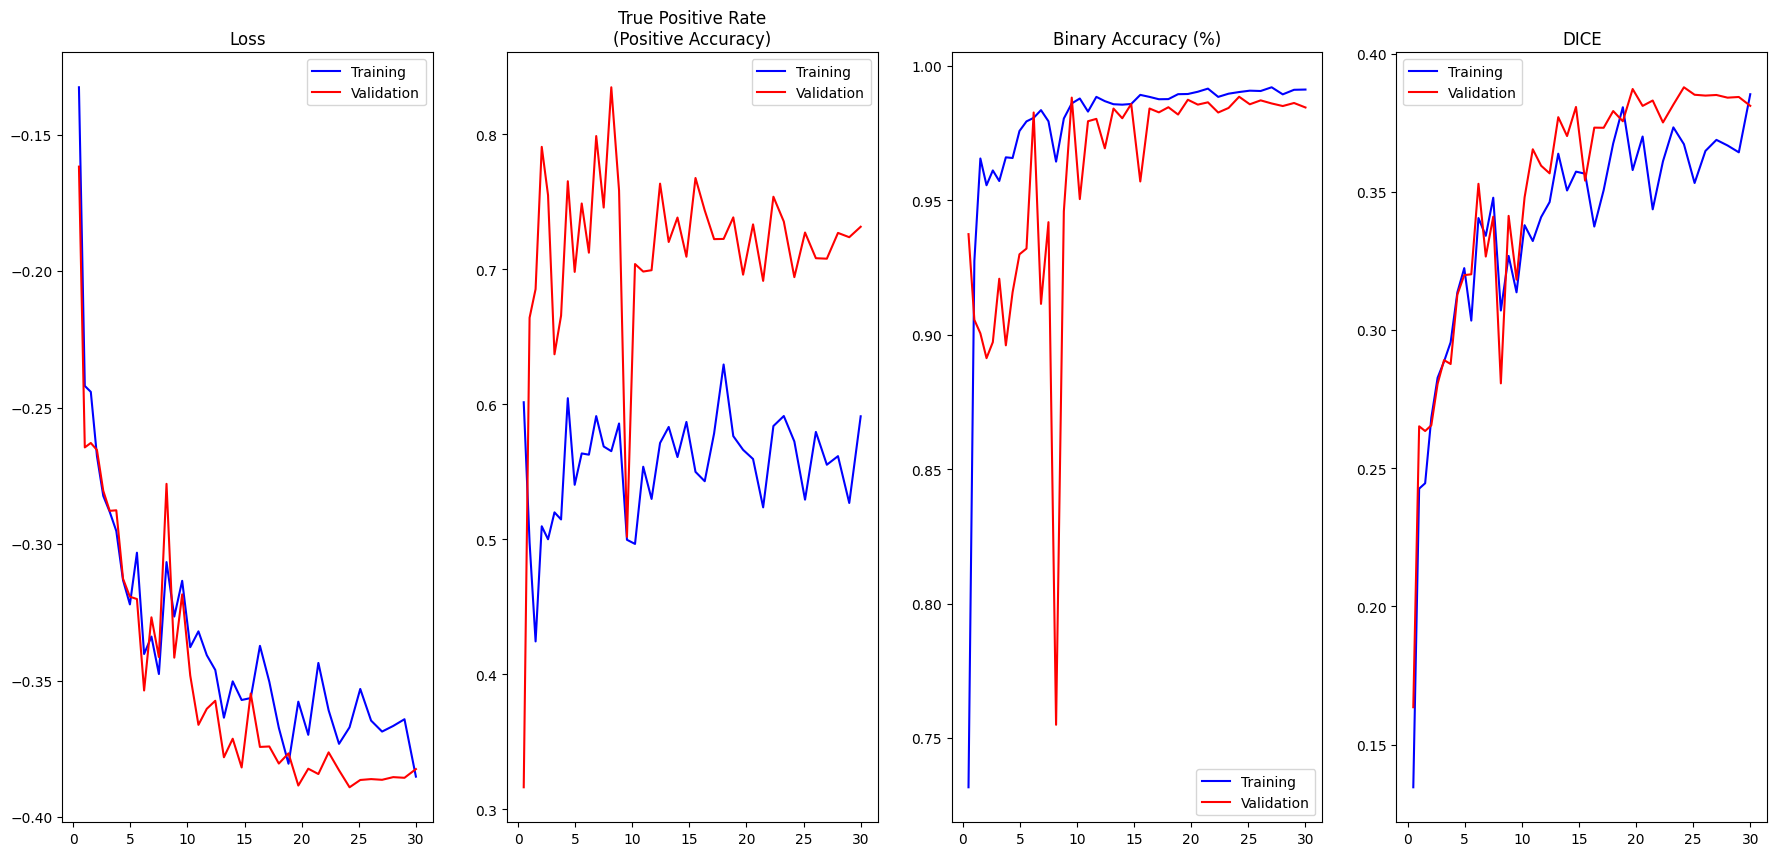

In [23]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [ ]:
# seg_model.load_weights(weight_path)
# seg_model_all.save('seg_model_2.h5')

valid_x, valid_y = next(valid_gen)

pred_y = seg_model_all.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log')

In [ ]:
# from keras.models import load_model
# load_model(checkpoint_filepath)

In [ ]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

# Improoving the model 

To improve the quality of the model we can use:

Search and kick off an outliers (bag satellite images)

Image pre-processing such as Equalization, Contrast stretching, Adaptive Equalization

Use a different metric. The problem is that there are very few pixels that ships occupy. This results in a strong imbalance of the positive and negative classes in one image. Analysis of publications shows that instead of the dice coefficient, you can use, for example, focal loss.

The current neural network must perform two tasks: classification (there are or are not ships in the photo) and segmentation, if any. You can break these tasks down: one neural network predicts whether there are ships in the photo. And the other segments. Presumably, a network trained only on pictures of ships will have greater accuracy.

Analysis of publications shows that the use of pre-trained models (for example, Unet34) improves the metric.